## GB2 대로 전처리 해보기
- EDA: [Extensive EDA and Modeling XGB Hyperopt](https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt)
- modeling: [IEEE - GB-2 (make Amount useful again)](https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again)
- feature engineering 중점 사항: 이걸 하나씩 바꿔 가면서 정확도 해보기!! submission 파일 따로 저장하고 **커밋시 메시지에 해당 내용 꼭 쓰기**
    - null 데이터는 일단 그대로 두기
    - P_emaildomain: boolean으로. mail.com or not
    - R_emaildomain: boolean으로? apple.com or not
    - id_23: ip_proxy or not? ip_proxy는 사기치려고 들어오는 사람들.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, gc, warnings, random
print(os.listdir("../input"))

import lightgbm as lgb

from tqdm import tqdm

import math
warnings.filterwarnings('ignore')

#standard plotly imports
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode

#import cufflinks
import plotly.figure_factory as ff

#using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)

#preprocessing, modeling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

['df_id.pkl', 'df_pca.pkl', 'df_test.pkl', 'df_train.pkl', 'df_trans.pkl', 'sample_submission.csv', 'test.pkl', 'test_0823.pkl', 'test_identity.csv', 'test_transaction.csv', 'train_0823.pkl', 'train_identity.csv', 'train_transaction.csv']


In [2]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
        end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# PCA 안하고, 메일 처리 안한 거로 읽기(mail.com 살리기 위해)
df_train = pd.read_pickle("../input/df_train.pkl")
df_test = pd.read_pickle("../input/df_test.pkl")
#must be 645.97
print("{:1.2f} Mb".format(df_train.memory_usage().sum() / 1024**2))
#must be 561.50
print("{:1.2f} Mb".format(df_test.memory_usage().sum() / 1024**2)) 

645.97 Mb
561.50 Mb


In [4]:
total = len(df_train)
total_amt = df_train['TransactionAmt'].sum()

def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()

In [5]:
df_train['P_emaildomain'].unique().shape

(60,)

In [ ]:
# 추가적인 전처리. mail.com 살리고 시각화 해보기(ploting_cnt_amt)
# df_train.P_emaildomain.fillna("NoInf", inplace=True)
# df_test.R_emaildomain.fillna("NoInf", inplace=True)

# dict에서 mail.com 만 제거
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    # bin -> emails dict에 따라 매핑(수정)
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    
    # suffix -> 도메인 중 맨 마지막(. 뒤에) 부분
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    
    # suffix 확인 -> us_email 값에 해당 안하면 그대로. 해당하면 'us'로
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

isFraud   P_emaildomain    NoFraud      Fraud
38       protonmail.com  59.210526  40.789474
29             mail.com  81.037567  18.962433
36           outlook.es  86.986301  13.013699
0               aim.com  87.301587  12.698413
35          outlook.com  90.541601   9.458399
21           hotmail.es  93.442623   6.557377
26          live.com.mx  94.526035   5.473965


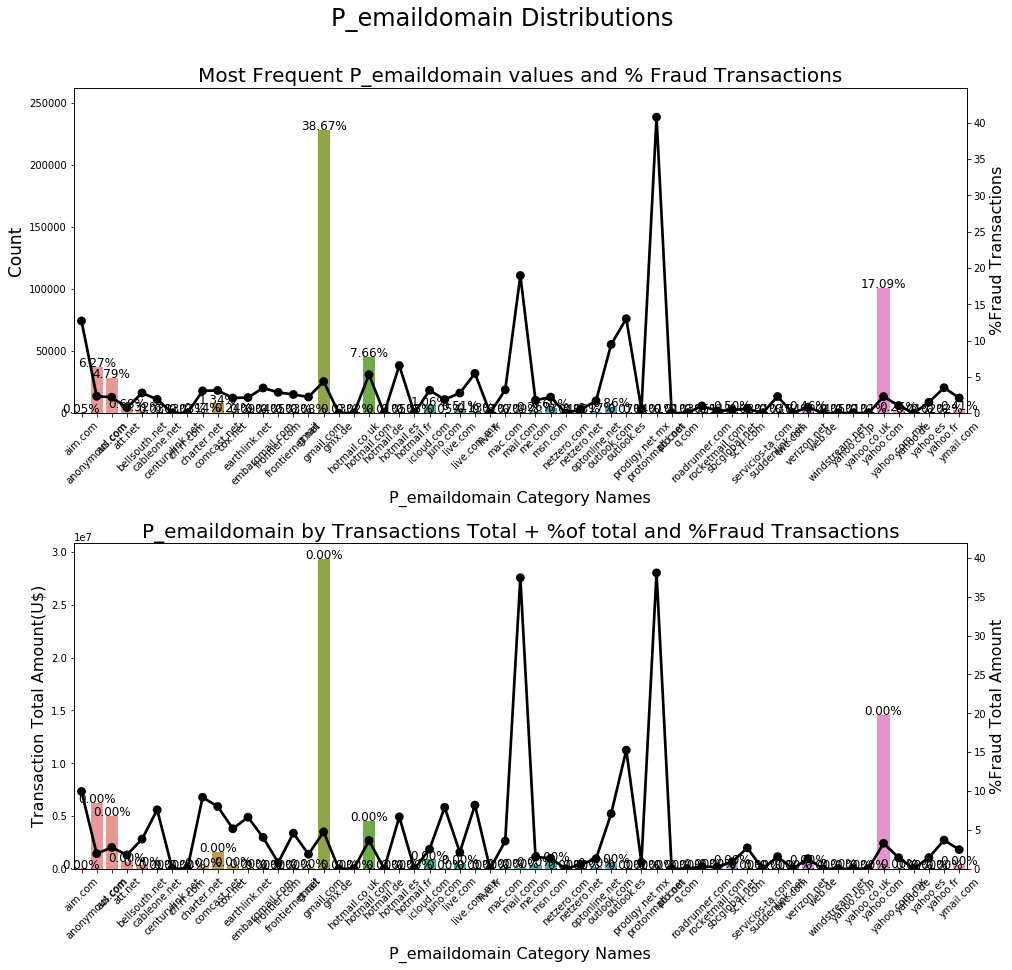

In [8]:
# reshape위해 float16 -> float64로 형식 변경.
# 모델링 할 때 다시 바꾸기!!
df_train['TransactionAmt'] = df_train['TransactionAmt'].astype('float64')

# Fraud % 높은 이메일 도메인 보기
# count까지 고려해야 하나? 상당히 비율은 작음.
tmp = pd.crosstab(df_train['P_emaildomain'], df_train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
print(tmp.sort_values(by='Fraud', ascending=False).head(7))

#df_train['P_emaildomain'] = (df_train['P_emaildomain'] == 'mail.com')
ploting_cnt_amt(df_train, 'P_emaildomain')

isFraud   R_emaildomain    NoFraud      Fraud  count
38       protonmail.com   4.878049  95.121951    NaN
29             mail.com  62.295082  37.704918    NaN
33          netzero.net  77.777778  22.222222    NaN
35          outlook.com  83.486239  16.513761    NaN
36           outlook.es  86.836028  13.163972    NaN
23           icloud.com  87.124464  12.875536    NaN
16            gmail.com  88.081614  11.918386    NaN


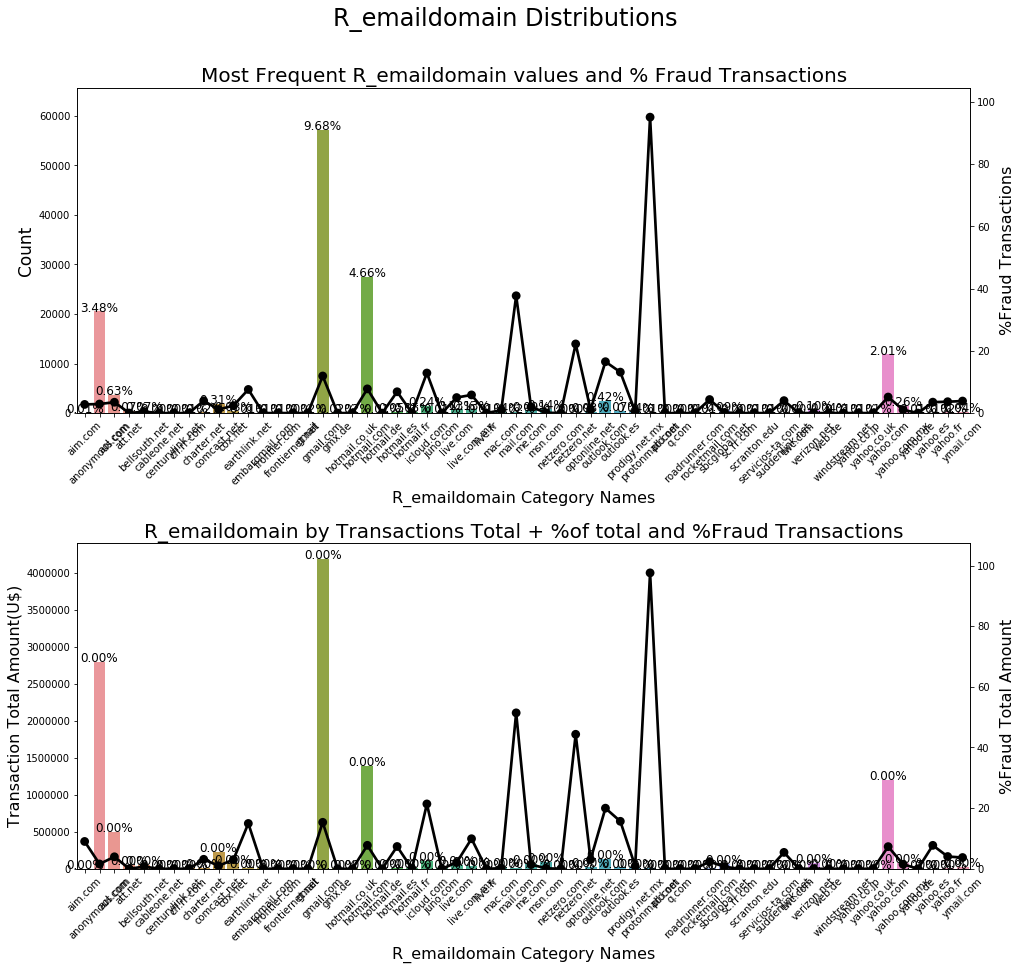

In [16]:
# R_emaildomain은 애매함. 일단 놔두기
# 근데 이거로 봤을때 Fraud%가 높은 것들이 있음. 이걸로 binary를 판단하기?
tmp = pd.crosstab(df_train['R_emaildomain'], df_train['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp['count'] = df_train['R_emaildomain'].value_counts()[
    df_train['R_emaildomain'].value_counts().index == tmp['R_emaildomain']
]
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
print(tmp.sort_values(by='Fraud', ascending=False).head(7))
# df_train['R_emaildomain'] = ((df_train['R_emaildomain'] == 'icloud.com') |
#                             (df_train['R_emaildomain'] == 'icloud.com'))
ploting_cnt_amt(df_train, 'R_emaildomain')

In [24]:
#tmp['R_emaildomain']
df_train['R_emaildomain'].value_counts()[
    df_train['R_emaildomain'].value_counts().index == tmp['R_emaildomain']
]

mail.com    122
Name: R_emaildomain, dtype: int64